In [1]:
import pickle
import numpy as np
from load_pickle import get_outputs
from itertools import product
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import io
from scipy import stats
import pandas as pd
import seaborn as sns
import os
import sys

cwd = os.getcwd()
sys.path.append(cwd+"/../handy_functions")

from scipy.stats import mannwhitneyu, normaltest, circvar
from statannotations.Annotator import Annotator
from scipy.stats import circvar
from utils import *
from pull_pickles import make_DF, print_df

data_folder = '/Users/kendranoneman/Projects/mayo/data/neural-decoding/outpickles/'
fig_folder='/Users/kendranoneman/Projects/mayo/NeuralDecoding/figures/' 

#colors2 = ['purple', 'blue','cyan','mediumaquamarine','green','yellowgreen','gold','orange', 'magenta', 'red','gray'] #Colors to plot each method
colors = ['mediumorchid','seagreen','cornflowerblue','gold']

sessions = [18,20,22,24,28,29,32,33,34,38]

In [2]:
units = pd.DataFrame()
for s in sessions:
    u = pd.read_csv(cwd+'/../datasets/units-pa{:0>2d}dir4A-pre500-post300.csv'.format(s))
    units = pd.concat([units,u],ignore_index=True)

#make_DF(sessions)
DF = pd.read_csv(cwd+'/out.csv')
DF.head(5)

,sess,repeat,outerFold,nMT,nFEF,R2,rho,neuron_inds,snr_mn,snr_sem,...,vfr_sem,dm_mn,dm_sem,di_mn,di_sem,si_mn,si_sem,R2_norm,condition,num_neurons
0,18,0,0,0,2,0.001751,0.043729,[ 8 19],1.060119,0.002384,...,2.821905,0.023296,0.004286,0.038874,0.011970,0.012080,0.001887,0.766573,fef only,2
1,18,1,0,0,2,0.001152,0.040728,[11 21],1.054688,0.046538,...,0.490034,0.010924,0.005565,0.021491,0.010891,0.006942,0.002211,0.766060,fef only,2
2,18,2,0,0,2,0.002906,0.112175,[ 9 21],0.962384,0.018730,...,5.002747,0.014199,0.007881,0.027763,0.015326,0.008086,0.003020,0.767563,fef only,2
3,18,3,0,0,2,-0.002421,0.048615,[ 1 20],1.116848,0.088201,...,11.341865,0.015491,0.000646,0.013120,0.006300,0.005189,0.000495,0.763000,fef only,2
4,18,4,0,0,2,-0.001472,-0.017541,[ 4 11],1.105753,0.010430,...,5.697432,0.014430,0.003086,0.028412,0.005997,0.008070,0.001414,0.763812,fef only,2


In [3]:
# Define function to output plot of the model coefficients
def coefplot(results,axes,col,reorderlist):
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    coef_df.columns = coef_df.iloc[0]
    coef_df=coef_df.drop(0)
    coef_df = coef_df.set_index(coef_df.columns[0])
    coef_df = coef_df.astype(float)
    
    errors = coef_df['coef'] - coef_df['[0.025']
    coef_df['errors'] = errors
    coef_df = coef_df.drop(['const'])
    coef_df = coef_df.sort_values(by=['coef'])

    variables = list(coef_df.index.values)
    coef_df['variables'] = variables
    #coef_df.sort_index(inplace=True,ascending=False) 
    coef_df = coef_df.iloc[pd.Categorical(coef_df.index,reorderlist).argsort()]
    
    if axes!=0:
        a = sns.pointplot(ax=axes, data=coef_df, x="variables", y="coef",errorbar="se", capsize=.2, color=col, order=reorderlist)
        coef_df.plot(x='variables', y='coef', kind='bar', 
                     ax=axes, color='none',error_kw=dict(ecolor=col, lw=2, capsize=5, capthick=2), 
                     yerr='errors', legend=False)
        axes.axhline(y=0, linestyle='--', color='black', linewidth=1)
    else:
        ax = plt.gca()
        a = sns.pointplot(ax=ax, data=coef_df, x="variables", y="coef",errorbar="se", capsize=.4, color=col, order=reorderlist)
        coef_df.plot(x='variables', y='coef', kind='bar', 
                     ax=ax, color='none',error_kw=dict(ecolor=col, lw=2, capsize=5, capthick=2), 
                     yerr='errors', legend=False)
        ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    
    a.set(xlabel=None)
    a.set(ylabel=None)
    
    return a

### Linear Regression ....... $\bf{N_{MT}}$ AND $\bf{N_{FEF}}$  --> $\bf{R^2}$

In [ ]:
# INDIVIDUAL SESSIONS

from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

fig, axes = plt.subplots(2,int(len(sessions)/2),figsize=(10,5), sharey=True, sharex=True) #Create figure (11 rows by 3 columns)
fig.tight_layout(w_pad=0.1)

for s in range(len(sessions)):
    df = DF.groupby(['nMT','nFEF','sess','condition','repeat','outerFold'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()
    df = df.loc[df['sess'] == sessions[s]]
    df = df[['R2','nMT','nFEF']]
    df['R2'] = stats.zscore(df['R2'])
    df['nMT'] = stats.zscore(df['nMT'])
    df['nFEF'] = stats.zscore(df['nFEF'])
    
    X = sm.add_constant(df[["nMT","nFEF"]])
    y = df[["R2"]]
    model = sm.OLS(y, X)
    results = model.fit()

    if s<5:
        r=0
        c=s
    else:
        r=1
        c=s-5
    
    reorderlist = [ 'nMT', 'nFEF']
    a = coefplot(results,axes[r,c],'black',reorderlist)
    a.set_title('s'+str(sessions[s]),loc='center')
    _ = a.set_xticklabels(list(['$N_{MT}$','$N_{FEF}$']),rotation=0, fontsize=12)

fig.subplots_adjust(left=0.08)
fig.subplots_adjust(bottom=0.1)
fig.text(0.5, 0.01, 'Number of Neurons', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Regression Coefficient', va='center', rotation='vertical', fontsize=14)

In [ ]:
# ALL SESSIONS

from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

fig = plt.figure(figsize=(5,4)) #Create figure (11 rows by 3 columns)
#fig.tight_layout(w_pad=0.1)


df = DF.groupby(['nMT','nFEF','sess','condition','repeat'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()
df = df[['nMT','nFEF','R2']]
df['R2'] = stats.zscore(df['R2'])
df['nMT'] = stats.zscore(df['nMT'])
df['nFEF'] = stats.zscore(df['nFEF'])

X = sm.add_constant(df[["nMT","nFEF"]])
y = df[["R2"]]
model = sm.OLS(y, X)
results = model.fit()

reorderlist = [ 'nMT', 'nFEF']
a = coefplot(results,0,'black',reorderlist)
a.set_title('all sessions',loc='center')
_ = a.set_xticklabels(list(['$N_{MT}$','$N_{FEF}$']), 
                       rotation=0, fontsize=12)
fig.text(0.5, 0.01, 'Number of Neurons', ha='center', fontsize=12)
fig.text(0.01, 0.5, 'Regression Coefficient', va='center', rotation='vertical', fontsize=12)

plt.show()

### Linear Regression ....... $\bf{N_{MT}}$ AND $\bf{N_{FEF}}$  --> $\bf{R^2}$

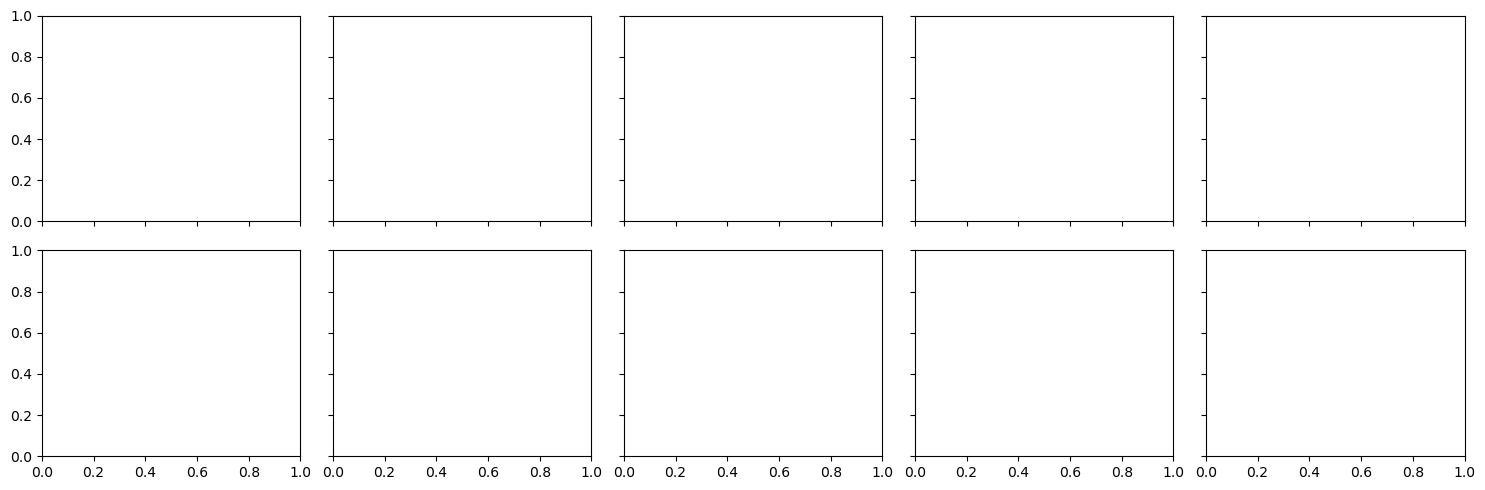

In [ ]:
# INDIVIDUAL SESSIONS

from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
%matplotlib inline
import ipywidgets as widgets

my_slider1 = widgets.IntSlider(
    value=12,
    min=0,
    max=26,
    step=2,
    description='# of MT neurons:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
my_slider2 = widgets.IntSlider(
    value=12,
    min=0,
    max=40,
    step=2,
    description='# of FEF neurons:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def f(var1,var2):
    fig, axes = plt.subplots(2,int(len(sessions)/2),figsize=(15,5), sharey=True, sharex=True) #Create figure (11 rows by 3 columns)
    fig.tight_layout(w_pad=0.1)

    for s in range(len(sessions)):
        df = DF.groupby(['nMT','nFEF','sess','condition','repeat','outerFold'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()
        df = df.loc[(df['sess'] == sessions[s]) & (df['nMT'] == var1) & (df['nFEF'] == var2)]
        print(df.shape)
        df = df[['R2','snr_mn','pd_sem','di_mn']]
        df['R2'] = stats.zscore(df['R2'])
        df['snr_mn'] = stats.zscore(df['snr_mn'])
        df['pd_sem'] = stats.zscore(df['pd_sem'])
        df['di_mn'] = stats.zscore(df['di_mn'])

        X = sm.add_constant(df[["snr_mn","pd_sem","di_mn"]])
        y = df[["R2"]]
        if s<5:
            r=0
            c=s
        else:
            r=1
            c=s-5
        while True:
            try:
                model = sm.OLS(y, X)
                results = model.fit()
                
                reorderlist = [ 'snr_mn', 'pd_sem', 'di_mn']
                a = coefplot(results,axes[r,c],'black',reorderlist)
                a.set_title('s'+str(sessions[s]),loc='center')
                a.set_ylim((-0.4,0.8))
                _ = a.set_xticklabels(list(['$SNR_{mean}$','$PD_{sem}$','$DI_{mean}$']), 
                                   rotation=0, fontsize=12)
                break
            except ValueError:
                axes[r,c].cla()
        

    fig.subplots_adjust(left=0.08)
    fig.subplots_adjust(bottom=0.1)
    fig.text(0.5, 0.01, 'Number of Neurons', ha='center', fontsize=14)
    fig.text(0.01, 0.5, 'Regression Coefficient', va='center', rotation='vertical', fontsize=14)
    
widgets.interact(f, var1 = my_slider1, var2 = my_slider2)

In [ ]:
# ALL SESSIONS

from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
%matplotlib inline
import ipywidgets as widgets

my_slider1 = widgets.IntSlider(
    value=12,
    min=0,
    max=22,
    step=2,
    description='# of MT neurons:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
my_slider2 = widgets.IntSlider(
    value=12,
    min=0,
    max=22,
    step=2,
    description='# of FEF neurons:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def f(var1,var2):
    fig = plt.figure(figsize=(5,4))

    df = DF.groupby(['nMT','nFEF','sess','condition','repeat','outerFold'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()
    df = df.loc[(df['nMT'] == var1) & (df['nFEF'] == var2)]
    df = df[['R2','snr_mn','pd_sem','di_mn']]
    df['R2'] = stats.zscore(df['R2'])
    df['snr_mn'] = stats.zscore(df['snr_mn'])
    df['pd_sem'] = stats.zscore(df['pd_sem'])
    df['di_mn'] = stats.zscore(df['di_mn'])

    X = sm.add_constant(df[["snr_mn","pd_sem","di_mn"]])
    y = df[["R2"]]
    model = sm.OLS(y, X)
    results = model.fit()

    reorderlist = [ 'snr_mn', 'pd_sem', 'di_mn']
    a = coefplot(results,0,'black',reorderlist)
    a.set_ylim((-0.1,0.8))
    a.set_title('all sessions',loc='center')
    _ = a.set_xticklabels(list(['$SNR_{mean}$','$PD_{sem}$','$DI_{mean}$']), 
                       rotation=0, fontsize=12)

    #fig.text(0.5, 0.01, 'Number of Neurons', ha='center', fontsize=14)
    fig.text(0.01, 0.5, 'Regression Coefficient', va='center', rotation='vertical', fontsize=12)
    
widgets.interact(f, var1 = my_slider1, var2 = my_slider2)

## SNR 

In [ ]:
# SNR DISTRIBUTIONS
palette = {'MT': colors[0],'FEF': colors[1]}
a = sns.displot(units, x="SNR", hue="BrainArea", col="Session", binwidth=0.25, palette=palette, height=4, col_wrap=5,hue_order=["MT","FEF"])
def specs(x,hue, **kwargs):
    plt.axvline(x[hue=='MT'].mean(), c=colors[0], ls='--', lw=2)
    plt.axvline(x[hue=='FEF'].mean(), c=colors[1], ls='--', lw=2)
    plt.text(4, 20, 'n: {:d}'.format(x[hue=='MT'].size),color=colors[0])
    plt.text(4, 19, 'mean: {:.2f}'.format(x[hue=='MT'].mean()),color=colors[0])
    plt.text(4, 18, 'std: {:.2f}'.format(x[hue=='MT'].std()),color=colors[0])
    plt.text(4, 16, 'n: {:d}'.format(x[hue=='FEF'].size),color=colors[1])
    plt.text(4, 15, 'mean: {:.2f}'.format(x[hue=='FEF'].mean()),color=colors[1])
    plt.text(4, 14, 'std: {:.2f}'.format(x[hue=='FEF'].std()),color=colors[1])
    _, p = mannwhitneyu(x[hue=='MT'],x[hue=='FEF'],method="auto")
    plt.text(4, 12, 'p = {:.3f}'.format(p),color='black')

a.map(specs,'SNR','BrainArea')
a.set(yticks=np.arange(0,25,5))
a.tight_layout(w_pad=1)
a.set(xlabel=None)
a.set(ylabel=None)

a.fig.text(0.47, 0.01, 'SNR', ha='center', fontsize=14)
a.fig.text(0.001, 0.5, 'Number of Units', va='center', rotation='vertical', fontsize=14)

a.savefig(fig_folder+'snr_dist.png', dpi=300, bbox_inches='tight')

In [ ]:
############ SNR v. R2: individual sessions ################

from scipy import stats

df = DF.groupby(['num_neurons','sess','condition','repeat'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()
df = df.loc[(df['num_neurons'] == 12) & (df['condition'] != 'mt+fef')]
df['R2_zscore'] = df.groupby(['condition','sess']).R2.transform(lambda x : stats.zscore(x,ddof=1)).values
df['snr_mn_zscore'] = df.groupby(['condition','sess']).snr_mn.transform(lambda x : stats.zscore(x,ddof=1)).values
df.sort_values(by='condition', ascending=False)
palette = {'mt only': colors[0],'fef only': colors[1],'mt=fef': colors[2]}
hue_order = [ 'fef only', 'mt only','mt=fef']

a = sns.lmplot(data=df, x="snr_mn", y="R2", hue="condition",hue_order=hue_order,palette=palette,col='sess',col_wrap=5,facet_kws={'sharey': False, 'sharex': False})
def specs(data,**kws):
    ax = plt.gca()
    
    g = data.condition.unique()[0]
    if g=='mt only':
        col = colors[0]
        y_pos = 0.9
    elif g=='fef only':
        col = colors[1]
        y_pos = 0.85
    else:
        col = colors[2]
        y_pos = 0.8
    
    r, p = stats.pearsonr(data['snr_mn'], data['R2'])
    ax.text(0.8, y_pos, r"$\rho$"+'={:.2f} ({:.3f})'.format(r, p),color=col, transform = ax.transAxes)
    
_ = a.map_dataframe(specs)

a.tight_layout(w_pad=1)
a.set(xlabel=None)
a.set(ylabel=None)

a.fig.text(0.47, 0.01, 'SNR (mean across neurons)', ha='center', fontsize=16)
a.fig.text(0.001, 0.5, 'Prediction Accuracy ($R^2$)', va='center', rotation='vertical', fontsize=16)

a.savefig(fig_folder+'snrVr2.png', dpi=300, bbox_inches='tight')

In [ ]:
############ SNR v. R2: all sessions ################
from scipy import stats
%matplotlib inline
import ipywidgets as widgets

my_slider = widgets.IntSlider(
    value=12,
    min=2,
    max=24,
    step=2,
    description='My Slider:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

df = DF.groupby(['num_neurons','sess','condition','repeat'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()

def f(var):
    df = DF.groupby(['num_neurons','sess','condition','repeat'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()
    df = df.loc[(df['num_neurons'] == var) & (df['condition'] != 'mt+fef')]
    df['R2_zscore'] = df.groupby(['condition']).R2.transform(lambda x : stats.zscore(x,ddof=1)).values
    df['snr_mn_zscore'] = df.groupby(['condition']).snr_mn.transform(lambda x : stats.zscore(x,ddof=1)).values
    df.sort_values(by='condition', ascending=False)
    palette = {'mt only': colors[0],'fef only': colors[1],'mt=fef': colors[2]}

    a = sns.lmplot(data=df, x="snr_mn", y="R2", hue="condition",palette=palette)
    def specs(data,**kws):
        ax = plt.gca()

        g = data.condition.unique()[0]
        if g=='mt only':
            col = colors[0]
            y_pos = 0.3
        elif g=='fef only':
            col = colors[1]
            y_pos = 0.25
        else:
            col = colors[2]
            y_pos = 0.2

        r, p = stats.pearsonr(data['snr_mn'], data['R2'])
        ax.text(0.8, y_pos, r"$\rho$"+'={:.2f} ({:.3f})'.format(r, p),color=col, transform = ax.transAxes)

    _ = a.map_dataframe(specs)

    a.tight_layout(w_pad=1)
    a.set(xlabel=None)
    a.set(ylabel=None)

    a.fig.text(0.47, 0.01, 'SNR (mean across neurons)', ha='center', fontsize=14)
    a.fig.text(0.001, 0.5, 'Prediction Accuracy ($R^2$)', va='center', rotation='vertical', fontsize=14)

widgets.interact(f, var = my_slider)

#a.savefig(fig_folder+'snrVr2_allSess.png', dpi=300, bbox_inches='tight')

In [ ]:
############ SVM (SNR v. R2): individual sessions #################

from plotting_fxns import svm_cloud
fig, axes = plt.subplots(2,int(len(sessions)/2),figsize=(25,10)) #Create figure (11 rows by 3 columns)
fig.tight_layout(w_pad=2)
for s in range(len(sessions)):
    df = DF.loc[DF['sess'] == sessions[s]]
    df = df.loc[(df['num_neurons'] == 12) & (df['condition'] != 'mt+fef')]
    df = df.groupby(['num_neurons','sess','condition','repeat'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()
    
    df['R2_zscore'] = df.groupby(['condition']).R2.transform(lambda x : stats.zscore(x,ddof=1)).values
    df['snr_mn_zscore'] = df.groupby(['condition']).snr_mn.transform(lambda x : stats.zscore(x,ddof=1)).values
    conditions = [
        (df['condition'] == 'mt only'),
        (df['condition'] == 'fef only'),
        (df['condition'] == 'mt=fef')
        ]
    values = [int(float(0)), int(float(1)), int(float(2))]
    df['condition2'] = np.select(conditions, values)
    df = df.sample(frac=1).reset_index() 
    
    features = df[['snr_mn','R2']]
    label = df[['condition2']]
    colors = ['mediumorchid','seagreen','cornflowerblue','gold']
    if s<5:
        r=0
        c=s
    else:
        r=1
        c=s-5
       
    poly_accuracy = svm_cloud(features,label,axes[r,c],colors,sessions[s])
    
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(bottom=0.03)
fig.text(0.5, 0.01, 'SNR (mean across neurons)', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Prediction Accuracy ($R^2$)', va='center', rotation='vertical', fontsize=14)
    
fig.savefig(fig_folder+'svm_snrVr2.png', dpi=300, bbox_inches='tight')

## Preferred direction

In [ ]:
# SNR DISTRIBUTIONS
palette = {'MT': colors[0],'FEF': colors[1]}
a = sns.displot(units, x="PrefDirFit", hue="BrainArea", col="Session", binwidth=45, palette=palette, height=4, col_wrap=5,hue_order=["MT","FEF"])

def specs(x,hue, **kwargs):
    plt.axvline(x[hue=='MT'].mean(), c=colors[0], ls='--', lw=2)
    plt.axvline(x[hue=='FEF'].mean(), c=colors[1], ls='--', lw=2)
    plt.text(4, 20, 'n: {:d}'.format(x[hue=='MT'].size),color=colors[0])
    plt.text(4, 19, 'mean: {:.2f}'.format(x[hue=='MT'].mean()),color=colors[0])
    plt.text(4, 18, 'std: {:.2f}'.format(x[hue=='MT'].std()),color=colors[0])
    plt.text(4, 16, 'n: {:d}'.format(x[hue=='FEF'].size),color=colors[1])
    plt.text(4, 15, 'mean: {:.2f}'.format(x[hue=='FEF'].mean()),color=colors[1])
    plt.text(4, 14, 'std: {:.2f}'.format(x[hue=='FEF'].std()),color=colors[1])
    _, p = mannwhitneyu(x[hue=='MT'],x[hue=='FEF'],method="auto")
    plt.text(4, 12, 'p = {:.3f}'.format(p),color='black')

a.map(specs,'PrefDirFit','BrainArea')
a.set(yticks=np.arange(0,25,5))
a.tight_layout(w_pad=1)
a.set(xlabel=None)
a.set(ylabel=None)

a.fig.text(0.47, 0.01, 'Preferred Direction', ha='center', fontsize=14)
a.fig.text(0.001, 0.5, 'Number of Units', va='center', rotation='vertical', fontsize=14)

a.savefig(fig_folder+'prefDir_dist.png', dpi=300, bbox_inches='tight')

In [ ]:
############ varPrefDir v. R2: individual sessions ################

from scipy import stats

df = DF.groupby(['num_neurons','sess','condition','repeat'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()
#df = DF
df = df.loc[(df['num_neurons'] == 12) & (df['condition'] != 'mt+fef')]
#df['R2_zscore'] = df.groupby(['condition','sess']).R2.transform(lambda x : stats.zscore(x,ddof=1)).values
#df['snr_mn_zscore'] = df.groupby(['condition','sess']).snr_mn.transform(lambda x : stats.zscore(x,ddof=1)).values
df.sort_values(by='condition', ascending=False)
palette = {'mt only': colors[0],'fef only': colors[1],'mt=fef': colors[2]}
hue_order = [ 'fef only', 'mt only','mt=fef']

a = sns.relplot(data=df, x="pd_sem", y="R2", hue="condition",hue_order=hue_order,palette=palette,col='sess',col_wrap=5,size=df['num_neurons'],facet_kws={'sharey': False, 'sharex': True})
def specs(x,y,hue,**kwargs):
    ax = plt.gca()
    p = stats.pearsonr(x[hue=='mt only'].values, y[hue=='mt only'].values)
    ax.text(0.8, 0.9, r"$\rho$"+'={:.2f} ({:.3f})'.format(p.statistic, p.pvalue),color=colors[0], transform = ax.transAxes)
    p = stats.pearsonr(x[hue=='fef only'].values, y[hue=='fef only'].values)
    ax.text(0.8, 0.85, r"$\rho$"+'={:.2f} ({:.3f})'.format(p.statistic, p.pvalue),color=colors[1], transform = ax.transAxes)
    p = stats.pearsonr(x[hue=='mt=fef'].values, y[hue=='mt=fef'].values)
    ax.text(0.8, 0.8, r"$\rho$"+'={:.2f} ({:.3f})'.format(p.statistic, p.pvalue),color=colors[2], transform = ax.transAxes)
    ax.set_xlim((0,70))
a.map(specs,'pd_sem','R2','condition')

a.tight_layout(w_pad=1)
a.set(xlabel=None)
a.set(ylabel=None)


a.fig.text(0.47, 0.01, 'Preferred Direction (circular SEM)', ha='center', fontsize=16)
a.fig.text(0.001, 0.5, '$R^2$', va='center', rotation='vertical', fontsize=16)

a.savefig(fig_folder+'pdvarVr2.png', dpi=300, bbox_inches='tight')

In [ ]:
############ varPrefDir v. R2: all sessions ################
from scipy import stats

df = DF.groupby(['num_neurons','sess','condition','repeat'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()
#df = DF
df = df.loc[(df['num_neurons'] == 12) & (df['condition'] != 'mt+fef')]
#df['R2_zscore'] = df.groupby(['condition','sess']).R2.transform(lambda x : stats.zscore(x,ddof=1)).values
#df['snr_mn_zscore'] = df.groupby(['condition','sess']).snr_mn.transform(lambda x : stats.zscore(x,ddof=1)).values
df.sort_values(by='condition', ascending=False)
palette = {'mt only': colors[0],'fef only': colors[1],'mt=fef': colors[2]}
hue_order = ['fef only', 'mt only','mt=fef']

a = sns.relplot(data=df, x="pd_sem", y="R2", hue="condition",palette=palette,size=df['num_neurons'])
def specs(x,y,hue,**kwargs):
    ax = plt.gca()
    p = stats.pearsonr(x[hue=='mt only'].values, y[hue=='mt only'].values)
    ax.text(0.8, 0.9, r"$\rho$"+'={:.2f} ({:.3f})'.format(p.statistic, p.pvalue),color=colors[0], transform = ax.transAxes)
    p = stats.pearsonr(x[hue=='fef only'].values, y[hue=='fef only'].values)
    ax.text(0.8, 0.85, r"$\rho$"+'={:.2f} ({:.3f})'.format(p.statistic, p.pvalue),color=colors[1], transform = ax.transAxes)
    p = stats.pearsonr(x[hue=='mt=fef'].values, y[hue=='mt=fef'].values)
    ax.text(0.8, 0.8, r"$\rho$"+'={:.2f} ({:.3f})'.format(p.statistic, p.pvalue),color=colors[2], transform = ax.transAxes)
    ax.set_xlim((0,70))

a.map(specs,'pd_sem','R2','condition')
a.tight_layout(w_pad=1)
a.set(xlabel=None)
a.set(ylabel=None)

a.fig.text(0.47, 0.01, 'Preferred Direction (circular SEM)', ha='center', fontsize=14)
a.fig.text(0.001, 0.5, 'Prediction Accuracy ($R^2$)', va='center', rotation='vertical', fontsize=14)

a.savefig(fig_folder+'pdvarVr2_allSess.png', dpi=300, bbox_inches='tight')

## Based on the mean SNR and sem PD of a cluster of neurons, what was the decoding accuracy?

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(16,4)) #Create figure (11 rows by 3 columns)
fig.tight_layout(pad=1.5)
fig.subplots_adjust(left=0.01)

nn = 12
n_bins = 8

df = DF.loc[DF['condition'] != 'mt+fef'] #.loc[DF['sess'] == sessions[s]]
df = df.loc[(df['num_neurons'] == nn)]
#df = df.loc[(df['num_neurons'] <= np.array([df['nMT'].max(), df['nFEF'].max()]).min()) & (df['condition'] != 'mt+fef')]
#df = df.groupby(['num_neurons','sess','condition','repeat'])[['R2','rho','snr_mn','snr_sem','pd_sem','mfr_mn','mfr_sem','vfr_mn','vfr_sem','dm_mn','dm_sem','di_mn','di_sem','si_mn','si_sem']].mean().reset_index()

df['snr_binned'] = pd.qcut(df['snr_mn'], n_bins)
df["snr_bin"] = df["snr_binned"].apply(lambda x: round(x.left,1))
df['pd_binned'] = pd.qcut(df['pd_sem'], n_bins)
df["pd_bin"] = df["pd_binned"].apply(lambda x: round(x.left,1))


df_t = df.groupby(['snr_bin', 'pd_bin','condition'])["R2"].mean().reset_index(name="mean_R2")

# MT only
df2 = df.loc[(df['condition'] == 'mt only')]
df2 = df2[['snr_bin','pd_bin','R2']]
df_m = df2.groupby(['snr_bin', 'pd_bin'])["R2"].mean().reset_index(name="mean_R2")
result = df_m.pivot(index='snr_bin', columns='pd_bin', values='mean_R2')

a = sns.heatmap(ax=axes[0],data=result, cmap=sns.light_palette("mediumorchid", as_cmap=True), mask=result.isnull(), vmin=df_t['mean_R2'].min(), vmax=df_t['mean_R2'].max())
a.invert_yaxis()
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('{} MT neurons'.format(nn),loc='center')

# FEF only
df2 = df.loc[(df['condition'] == 'fef only')]
df2 = df2[['snr_bin','pd_bin','R2']]
df_m = df2.groupby(['snr_bin', 'pd_bin'])["R2"].mean().reset_index(name="mean_R2")
result = df_m.pivot(index='snr_bin', columns='pd_bin', values='mean_R2')

a = sns.heatmap(ax=axes[1],data=result, cmap=sns.light_palette("seagreen", as_cmap=True), mask=result.isnull(), vmin=df_t['mean_R2'].min(), vmax=df_t['mean_R2'].max())
a.invert_yaxis()
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('{} FEF neurons'.format(nn),loc='center')
a.set(yticklabels=[])

# FEF only
df2 = df.loc[(df['condition'] == 'mt=fef')]
df2 = df2[['snr_bin','pd_bin','R2']]
df_m = df2.groupby(['snr_bin', 'pd_bin'])["R2"].mean().reset_index(name="mean_R2")
result = df_m.pivot(index='snr_bin', columns='pd_bin', values='mean_R2')

a = sns.heatmap(ax=axes[2],data=result, cmap=sns.light_palette("cornflowerblue", as_cmap=True), mask=result.isnull(), vmin=df_t['mean_R2'].min(), vmax=df_t['mean_R2'].max())
a.invert_yaxis()
a.set(xlabel=None)
a.set(ylabel=None)
a.set_title('{} MT, {} FEF neurons'.format(int(nn/2),int(nn/2)),loc='center')
a.set(yticklabels=[])

fig.text(0.99, 0.5, 'Prediction Accuracy ($R^2$)', va='center', rotation=-90, fontsize=12)
fig.text(0, 0.5, 'SNR (mean)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0, 'Preferred Direction (circular SEM)', ha='center', fontsize=14)